# Example notebook on how to run `healvis`

In [24]:
%matplotlib inline
import numpy as np
import healvis as hv
import healpy as hp
import matplotlib.pyplot as plt
from healvis.data import DATA_PATH
import os
from pyuvdata import UVData

# Computing Visibilities

This section shows how to generate a flat-spectrum and a GSM model and compute visibilities.

## 1. Create the Observatory

In [32]:
# create a baseline
ant1_enu = np.array([0.0, 0.0, 0.0])  # meters
ant2_enu = np.array([15.0, 0.0, 0.0])  # meters
bl = hv.observatory.Baseline(ant1_enu, ant2_enu)
obs_latitude = -30.7215277777
obs_longitude = 21.4283055554

# set frequency axis
freqs = np.linspace(100e6, 150e6, 20, endpoint=False)
Nfreqs = len(freqs)

# set times: this is when galac
times = np.linspace(2458000.1, 2458000.3, 40)
Ntimes = len(times)

# create the observatory
fov = 360  # Deg
obs = hv.observatory.Observatory(obs_latitude, obs_longitude, array=[bl], freqs=freqs)
obs.set_pointings(times)
obs.set_fov(fov)

# set the beam
obs.set_beam(os.path.join(DATA_PATH, "HERA_NF_dipole_power.beamfits"))

## 2. Create a Sky

In [33]:
# create a noise-like sky
np.random.seed(0)
Nside = 32
Npix = hp.nside2npix(Nside)
eor = hv.sky_model.construct_skymodel("flat_spec", freqs=freqs, Nside=Nside, ref_chan=0, sigma=1.0)

# create a PyGSM sky
gsm = hv.sky_model.construct_skymodel('gsm', freqs=freqs, Nside=Nside, ref_chan=0)

In [55]:
from scipy.interpolate import interp1d
gsm = hv.sky_model.SkyModel()
gsm.read_hdf5(os.path.join(DATA_PATH, "gsm_nside32.hdf5"))


gsm.data = interp1d(gsm.freqs, gsm.data, axis=2, bounds_error=False, fill_value='extrapolate')(freqs)
gsm.freqs = freqs
gsm.Nfreqs = len(freqs)

...reading /Users/nkern/Software/anaconda2/lib/python2.7/site-packages/healvis-0.1.0-py2.7.egg/healvis/data/gsm_nside32.hdf5


In [51]:
# interpolate the beam to the SkyModel frequencies once
obs.beam.interp_freq(freqs, inplace=True, kind='cubic')

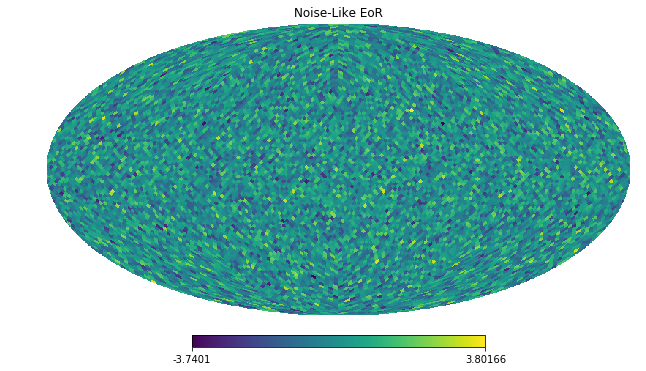

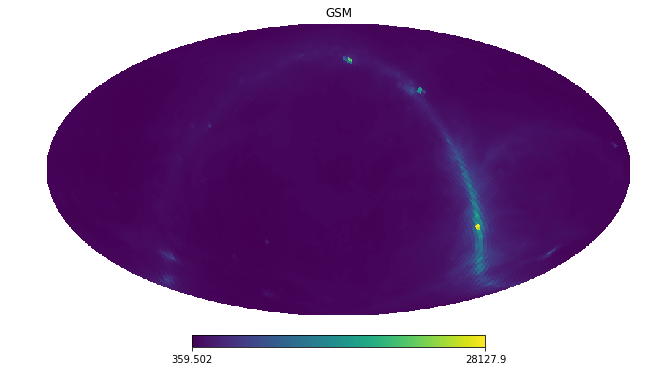

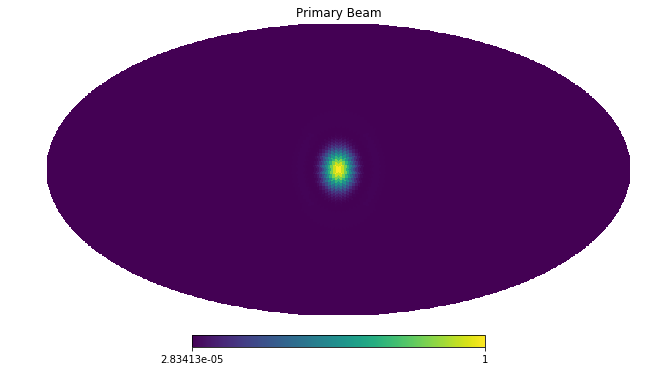

In [52]:
hp.mollview(eor.data[0, :, 0], title="Noise-Like EoR")
hp.mollview(gsm.data[0, :, 0], title="GSM")
hp.mollview(obs.beam.data_array[0, 0, 0, 0], title="Primary Beam", rot=[0, 90])

## 3. Compute Visibilities

In [38]:
%%time
eor_vis, times, bls = obs.make_visibilities(eor, beam_pol='XX')

CPU times: user 4.23 s, sys: 410 ms, total: 4.64 s
Wall time: 4.64 s


In [56]:
%%time
gsm_vis, times, bls = obs.make_visibilities(gsm, beam_pol='XX')

CPU times: user 4.44 s, sys: 433 ms, total: 4.87 s
Wall time: 4.89 s


Text(0.5,1,'GSM')

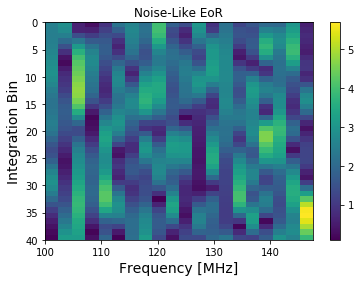

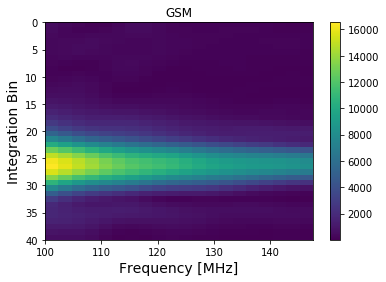

In [57]:
plt.figure()
plt.imshow(np.abs(eor_vis[:, 0, :]), aspect='auto',
           extent=[obs.freqs.min()/1e6, obs.freqs.max()/1e6, obs.Ntimes, 0])
plt.colorbar()
plt.xlabel("Frequency [MHz]", fontsize=14)
plt.ylabel("Integration Bin", fontsize=14)
plt.title("Noise-Like EoR")

plt.figure()
plt.imshow(np.abs(gsm_vis[:, 0, :]), aspect='auto',
           extent=[obs.freqs.min()/1e6, obs.freqs.max()/1e6, obs.Ntimes, 0])
plt.colorbar()
plt.xlabel("Frequency [MHz]", fontsize=14)
plt.ylabel("Integration Bin", fontsize=14)
plt.title("GSM")

See `healvis.simulator.run_simulation` for an automated way of simulating visibilities given an Observation Parameter `YAML` file. See `healvis/data/config/obsparam_test.yaml` for a template file.

# Memory Limitations
If the SkyModel and PowerBeam objects are too large to handle in memory for all desired frequencies, one can perform partial frequency simulations in serial to minimize instantaneous memory loads.
This can be done with `healvis.simulator.run_simulation_partial_freq`.

## 1. Setup
The first step is to write a SkyModel map to disk, and setup a setup a `pyuvdata` UVH5 file on disk matching the frequencies of the sky model.

In [35]:
# read gsm test file
skymod_file = os.path.join(DATA_PATH, "gsm_nside32.hdf5")
sky = hv.sky_model.SkyModel()
sky.read_hdf5(skymod_file)

# setup uvdata to match freq of gsm test file for a select number of baselines
bls = [(11, 12)]
uvd = hv.simulator.setup_uvdata(array_layout=os.path.join(DATA_PATH, "configs/HERA65_layout.csv"),
                                telescope_location=(-30.72152777777791, 21.428305555555557, 1073.0000000093132),
                                telescope_name="HERA", Ntimes=250, time_cadence=100.0, start_time=2458000.1,
                                pols=['xx'], bls=bls, run_check=True, freq_array=sky.freqs)
test_uvh5 = os.path.join(DATA_PATH, "example_freq_partial_sim.uvh5")
uvd.write_uvh5(test_uvh5, clobber=True)

...reading /Users/nkern/Software/anaconda2/lib/python2.7/site-packages/healvis-0.1.0-py2.7.egg/healvis/data/gsm_nside32.hdf5
File exists; clobbering


## 2. Run Simulation
The next step is to run the simulation given a channel range, beam model selection and observatory parameters.

In [36]:
# select frequency channels to simulate
freq_chans = np.arange(4)

# run simulation
beamfile = os.path.join(DATA_PATH, "HERA_NF_dipole_power.beamfits")
beam = hv.beam_model.PowerBeam(beamfile)
hv.simulator.run_simulation_partial_freq(freq_chans, test_uvh5, skymod_file, fov=180, beam=beam)

...reading /Users/nkern/Software/anaconda2/lib/python2.7/site-packages/healvis-0.1.0-py2.7.egg/healvis/data/gsm_nside32.hdf5
...writing to /Users/nkern/Software/anaconda2/lib/python2.7/site-packages/healvis-0.1.0-py2.7.egg/healvis/data/example_freq_partial_sim.uvh5


Now we can inspect the file to verify that partial frequencies were simulated

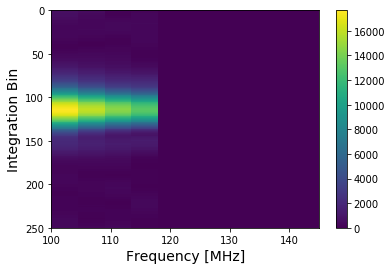

In [37]:
uvd_result = UVData()
uvd_result.read_uvh5(test_uvh5)

plt.imshow(np.abs(uvd_result.get_data(11, 12)), aspect='auto',
           extent=[uvd_result.freq_array.min()/1e6, uvd_result.freq_array.max()/1e6, uvd_result.Ntimes, 0])
plt.xlabel("Frequency [MHz]", fontsize=14)
plt.ylabel("Integration Bin", fontsize=14)
plt.colorbar()

One can then repeat this process for multiple subbands (in serial) to fill out the visibility.
Due to limitations with simultaneous writing to HDF5 files, one cannot currently run this operation in parallel with other subband simulations on the same output UVH5 file.

In [38]:
os.remove(test_uvh5)